# Text Classification with a Feedforward Network


The goal is to develop a Feedforward neural network for text classification.



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix**
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** 
    - **Output layer** with a **softmax** activation. 


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function
    - Perform a **Forward pass** to compute intermediate outputs 
    - Perform a **Backward pass** to compute gradients and update all sets of weights 
    - Implement and use **Dropout** after each hidden layer for regularisation



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination. 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right?



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? 



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations 


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors.


### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_set = pd.read_csv('./data_topic/train.csv', names=['label', 'text'])
dev_set = pd.read_csv('./data_topic/dev.csv', names=['label', 'text'])
test_set = pd.read_csv('./data_topic/test.csv', names=['label', 'text'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    
    # this is to store the ngrams to be returned
    x = []
    

    
    if ngram_range[0]==1:
        x = x_uni


    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)


    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x







### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [5]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

In [6]:
raw_text = train_set.text.to_list()
labels = train_set.label.to_numpy() - 1 # subtract 1 to change the label range from (1,3) to (0,2)

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
import time
start = time.time()
vocabulary, doc_freq, raw_freq = get_vocab(X_raw=raw_text, ngram_range=(1,1), stop_words=stop_words)
print(time.time() - start)

0.09075689315795898


In [8]:
raw_text_dev = dev_set.text.to_list()
labels_dev = dev_set.label.to_numpy() - 1 # subtract 1 to change the label range from (1,3) to (0,2)

raw_text_test = test_set.text.to_list()
labels_test = test_set.label.to_numpy() - 1 # subtract 1 to change the label range from (1,3) to (0,2)

In [9]:
vocabulary_dev, doc_freq_dev, raw_freq_dev = get_vocab(X_raw=raw_text_dev, ngram_range=(1, 1), stop_words=stop_words)
vocabulary_test, doc_freq_test, raw_freq_test = get_vocab(X_raw=raw_text_test, ngram_range=(1, 1), stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [10]:
voc_word = {}
word_voc = {}

for idx, word in enumerate(sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test))):
    voc_word[idx] = word
    word_voc[word] = idx

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [11]:
train_unigrams = list(extract_ngrams(x_raw=txt, ngram_range=(1, 1),
                                     vocab=sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test)), 
                                     stop_words=stop_words) for txt in raw_text)

dev_unigrams = list(extract_ngrams(x_raw=txt, ngram_range=(1, 1),
                                   vocab=sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test)),
                                   stop_words=stop_words) for txt in raw_text_dev)

test_unigrams = list(extract_ngrams(x_raw=txt, ngram_range=(1, 1),
                                    vocab=sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test)),
                                    stop_words=stop_words) for txt in raw_text_test)

Then convert them into lists of indices in the vocabulary:

In [12]:
train_idx = list([word_voc[x] for x in y] for y in train_unigrams)

dev_idx = list([word_voc[x] for x in y] for y in dev_unigrams)

test_idx = list([word_voc[x] for x in y] for y in test_unigrams)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [13]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    # fixing random seed for reproducibility
    np.random.seed(123)
    
    # Dimensions
    dim = [vocab_size, embedding_dim] + hidden_dim + [num_classes]

    # Weight initialisation (here He Initialisation)
    W = [np.random.randn(*size).astype(np.float32) * np.sqrt(2 / (size[0]))
         for size in zip(*(dim[i:] for i in range(2)))]

    return W
    

In [14]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [15]:
def softmax(z):
    sig = np.exp(z) / np.sum(np.exp(z))
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [16]:
def categorical_loss(y, y_preds):
    l = -1*np.log(y_preds[y])    
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [17]:
def relu(z):
    a = z.copy()
    a = a * ((a > 0).astype(int))    # ReLU: y = max(x,0) 
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz[dz<=0] = 0                    # d(relu(x)) = 0 if x < 0
    dz[dz>0] = 1                     # d(relu(x)) = 1 if x >= 0
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [18]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.random.choice([0, 1], size, p=[dropout_rate, 1 - dropout_rate])
    return dropout_vec

In [19]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1 1 1 1 0 1 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [20]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []


    # Embedding layer
    layer_1 = np.mean(W[0][x], axis=0)
    h_vecs.append(layer_1)

    out_1 = relu(layer_1)
    a_vecs.append(out_1)

    # Applying dropout mask to embedding layer
    dropout_vecs.append(dropout_mask(W[0].shape[1], dropout_rate))
    out_i = out_1 * dropout_vecs[-1]

    # Iterate over hidden layers
    for weights in W[1:-1]:
        layer_i = out_i.dot(weights)
        h_vecs.append(layer_i)

        out_i = relu(layer_i)
        a_vecs.append(out_i)

        dropout_vecs.append(dropout_mask(weights.shape[1], dropout_rate))
        out_i *= dropout_vecs[-1]

    # Softmax for output layer
    y = softmax(out_i.dot(W[-1]))

    out_vals = {'hidden_layers': h_vecs, 'outputs': a_vecs, 'dropout_vector': dropout_vecs, 'y': y}
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [21]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # gradient calculation of output layer
    grad = out_vals['y'] - (np.arange(len(out_vals['y'])) == y)

    # gradient calculation of weights
    out_layer_input = out_vals['outputs'][-1] * out_vals['dropout_vector'][-1]
    grad_on_wt = np.outer(grad, out_layer_input).T

    # Gradient propagation
    grad = grad.dot(W[-1].T)
    
    # Weight update
    W[-1] -= lr * grad_on_wt

    # Update each hidden layer
    for i in range(len(W) - 2, 1, -1):
        grad *= relu_derivative(out_vals['hidden_layers'][i])

        # gradient calculation of weights
        layer_input = out_vals['outputs'][i - 1] * out_vals['dropout_vector'][i - 1]
        grad_on_wt = np.outer(grad, layer_input).T

        # Gradient propagation
        grad = grad.dot(W[i].T)

        # Weight update
        W[i] -= lr * grad_on_wt

    # Update weights of the initial layer
    if not freeze_emb:
        grad *= relu_derivative(out_vals['hidden_layers'][0])
        W[0][x] -= lr * grad
    
    return W




Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [22]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    # fixing random seed for reproducibility
    np.random.seed(123)
    training_loss_history = []
    validation_loss_history = []

    # Training tuples
    train_docs = list(zip(X_tr, Y_tr))

    for epoch in range(epochs):
        # Shuffle the train docs
        np.random.shuffle(train_docs)

        for x_i, y_i in train_docs:
            W = backward_pass(x_i, y_i, W, forward_pass(x_i, W, dropout), lr, freeze_emb)

        # Training loss
        cur_loss_tr = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                               for x_i, y_i in train_docs])

        # Validation loss
        cur_loss_dev = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                                for x_i, y_i in zip(X_dev, Y_dev)])

        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)

        if print_progress:
            print(f'Epoch: {epoch} | Train loss: {cur_loss_tr} | Dev loss: {cur_loss_dev}')
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

Put the labels `Y` for train, dev and test sets into arrays: 

In [23]:
W = network_weights(vocab_size=len(sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test))),
                    embedding_dim=300, hidden_dim=[], num_classes=3)

W, loss_train,loss_dev = SGD(X_tr=train_idx, Y_tr=labels, W=W, X_dev=dev_idx, Y_dev=labels_dev,
                           lr=0.016, dropout=0.2, freeze_emb=False, epochs=54)


Shape W0 (11344, 300)
Shape W1 (300, 3)
Epoch: 0 | Train loss: 0.881275909589638 | Dev loss: 0.9594298091099738
Epoch: 1 | Train loss: 0.5362312974712302 | Dev loss: 0.6674442981919646
Epoch: 2 | Train loss: 0.3401338323924496 | Dev loss: 0.4791969983000304
Epoch: 3 | Train loss: 0.23960032845146187 | Dev loss: 0.39505032712917215
Epoch: 4 | Train loss: 0.17706325096923847 | Dev loss: 0.3462381190193138
Epoch: 5 | Train loss: 0.13775933159950668 | Dev loss: 0.32991714516567794
Epoch: 6 | Train loss: 0.1077219080650022 | Dev loss: 0.30670102439373004
Epoch: 7 | Train loss: 0.08800078090539495 | Dev loss: 0.2790697114315651
Epoch: 8 | Train loss: 0.07446441464902362 | Dev loss: 0.2804094326931601
Epoch: 9 | Train loss: 0.06252903752471463 | Dev loss: 0.27143164783134344
Epoch: 10 | Train loss: 0.0523227840367145 | Dev loss: 0.27451999486831313
Epoch: 11 | Train loss: 0.046904319198142946 | Dev loss: 0.2760631450155417
Epoch: 12 | Train loss: 0.040601805108514834 | Dev loss: 0.27935075962

Plot the learning process:

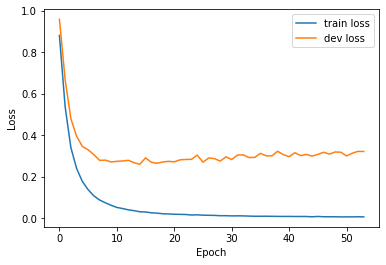

In [24]:
plt.plot(loss_train, label='train loss')
plt.plot(loss_dev, label='dev loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [25]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_idx,labels_test)]

print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))

Accuracy: 0.8511111111111112
Precision: 0.8529221450313959
Recall: 0.851111111111111
F1-Score: 0.8508610210397762


### Discuss how did you choose model hyperparameters ? 

The weights have been initialised by He weight initialisation method as it is proven to be effective with ReLU activation function

The optimal value of initial weights depends on the learning rate (lr), the embedding dimension (embedding_dim).

Coming to embedding dimension, if we select a too big value, the model might saturate (or stop to learn further) and overfit. In contrast if a value too small is selected, then the model might not learn the relation resulting in underfitting.

Hyperparameters to which model performed the best were Embedding dimension: 300, Learning rate: 0.016, Dropout rate: 0.2

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [26]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split(' ')[0]
                     
                if word in sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test)):
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [27]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id=word_voc)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [28]:
W = network_weights(vocab_size=len(sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test))),
                    embedding_dim=300,
                    num_classes=3)
W[0] = w_glove

W, tr_loss,_ = SGD(X_tr=train_idx, Y_tr=labels, W=W, X_dev=dev_idx, Y_dev=labels_dev,
                           lr=0.10, dropout=0.2, freeze_emb=True, epochs=35)

Shape W0 (11344, 300)
Shape W1 (300, 3)
Epoch: 0 | Train loss: 0.3879472010213065 | Dev loss: 0.32089311198962406
Epoch: 1 | Train loss: 0.36659137659716845 | Dev loss: 0.2636870253953373
Epoch: 2 | Train loss: 0.32386867178906137 | Dev loss: 0.23035256150574962
Epoch: 3 | Train loss: 0.3082061062895718 | Dev loss: 0.22479596213206635
Epoch: 4 | Train loss: 0.30023108545420374 | Dev loss: 0.22538128609198044
Epoch: 5 | Train loss: 0.29305444489672494 | Dev loss: 0.21034711939626793
Epoch: 6 | Train loss: 0.31575920664570284 | Dev loss: 0.22575548867080253
Epoch: 7 | Train loss: 0.29422720433468513 | Dev loss: 0.21750139090764767
Epoch: 8 | Train loss: 0.31242163714183446 | Dev loss: 0.26699559890439245
Epoch: 9 | Train loss: 0.3011365297118272 | Dev loss: 0.19985841588226805
Epoch: 10 | Train loss: 0.2749703134574406 | Dev loss: 0.19441751185499573
Epoch: 11 | Train loss: 0.2739111576877877 | Dev loss: 0.19051321697174667
Epoch: 12 | Train loss: 0.2981875026488866 | Dev loss: 0.2526677

In [29]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_idx,labels_test)]

print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))

Accuracy: 0.8777777777777778
Precision: 0.881207814988158
Recall: 0.8777777777777778
F1-Score: 0.8784433686789922


### Discuss how did you choose model hyperparameters ? 

### Optimising Hyperparameters

The hyperparameters need to be optimised are lr and dropout rate.


lr=0.10 has the highest F1-score at the cost of higher train and dev losses.

The dev loss is observed to be lower than the train loss for this model.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [30]:
W = network_weights(vocab_size=len(sorted(vocabulary.union(vocabulary_dev).union(vocabulary_test))),
                    embedding_dim=300,
                    hidden_dim=[1050],
                    num_classes=3)
W[0] = w_glove

W, tr_loss,_ = SGD(X_tr=train_idx, Y_tr=labels, W=W, X_dev=dev_idx, Y_dev=labels_dev,
                           lr=0.16, dropout=0.2, freeze_emb=True, epochs=5)

Shape W0 (11344, 300)
Shape W1 (300, 1050)
Shape W2 (1050, 3)
Epoch: 0 | Train loss: 0.45016398645141237 | Dev loss: 0.37786751470706403
Epoch: 1 | Train loss: 0.6163294902165168 | Dev loss: 0.4927191595260631
Epoch: 2 | Train loss: 0.4168952034156947 | Dev loss: 0.39715280688458904
Epoch: 3 | Train loss: 0.36326029786977565 | Dev loss: 0.26709534424918113
Epoch: 4 | Train loss: 0.3552192645896218 | Dev loss: 0.22526430485486004


In [31]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_idx,labels_test)]

print('Accuracy:', accuracy_score(labels_test,preds_te))
print('Precision:', precision_score(labels_test,preds_te,average='macro'))
print('Recall:', recall_score(labels_test,preds_te,average='macro'))
print('F1-Score:', f1_score(labels_test,preds_te,average='macro'))

Accuracy: 0.8788888888888889
Precision: 0.8799635825737934
Recall: 0.8788888888888889
F1-Score: 0.8787001963934108


### Discuss how did you choose model hyperparameters ? 

Increaing the number of hidden layers increases training time but doesn't necessarily translate into increase in performance.

This model is better but more complex to implement than Average Embedding Model.

In summary Pre-Trained Embeddings + Hidden Layer Model performs better than just Pre-Trained Embeddings Model at a cost of a significant amount of time for optimal hyperparameter tuning.

Hyperparameters to which model performed the best were hidden_dim=[1050], lr=0.16, dropout=0.2

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 85.29%  | 85.11%  | 85.08%  | 85.11%  |
| Average Embedding (Pre-trained)  | 88.12%  | 87.78%  | 87.84%  | 87.78%  |
| Average Embedding (Pre-trained) + X hidden layers    | 87.99%  | 87.88%  | 87.87%  | 87.88  |


###### Converting notebook to pdf

In [32]:
!python -m pip install -U notebook-as-pdf
!pyppeteer-install

  Attempting uninstall: notebook-as-pdf
    Found existing installation: notebook-as-pdf 0.4.0
    Uninstalling notebook-as-pdf-0.4.0:
      Successfully uninstalled notebook-as-pdf-0.4.0


[W:pyppeteer.command] chromium is already installed.


In [ ]:
jupyter-nbconvert --to pdfviahtml assignment2.ipynb